In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import time

In [2]:
# Directories for training, validation, and testing
train_dir = "/kaggle/input/undersample-majority/undersample_split/1.train"
val_dir = "/kaggle/input/undersample-majority/undersample_split/2.val"
test_dir = "/kaggle/input/undersample-majority/undersample_split/3.test"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
train_generator = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_generator = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Build a CNN Backbone (EfficientNetB0 as feature extractor)
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

# Add ViT layers
vit_input = Input(shape=(224, 224, 3))
x = base_model(vit_input, training=False)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile Model
model = Model(inputs=vit_input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=10)
training_time = time.time() - start_time

# Evaluate Model
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Found 467 images belonging to 7 classes.
Found 100 images belonging to 7 classes.
Found 101 images belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.1396 - loss: 3.5246 - val_accuracy: 0.1500 - val_loss: 2.0643
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 951ms/step - accuracy: 0.1230 - loss: 2.2073 - val_accuracy: 0.1500 - val_loss: 1.9484
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 986ms/step - accuracy: 0.1835 - loss: 1.9856 - val_accuracy: 0.1500 - val_loss: 1.9645
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 961ms/step - accuracy: 0.1501 - loss: 1.9916 - val_accuracy: 0.1500 - val_loss: 1.9455
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 969ms/step - accuracy: 0.1483 - loss: 1.9454 - val_accuracy: 0.1500 - val_loss: 1.9475
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1875 - loss: 1.9437 - val_accuracy: 0.1500 - val_loss: 1.9459
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 940ms/step - accuracy: 0.1428 - loss: 1.9459 - val_accuracy: 0.1500 - val_loss: 1.9459
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1363 - loss: 1.9459 - val_accuracy: 0.1500 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


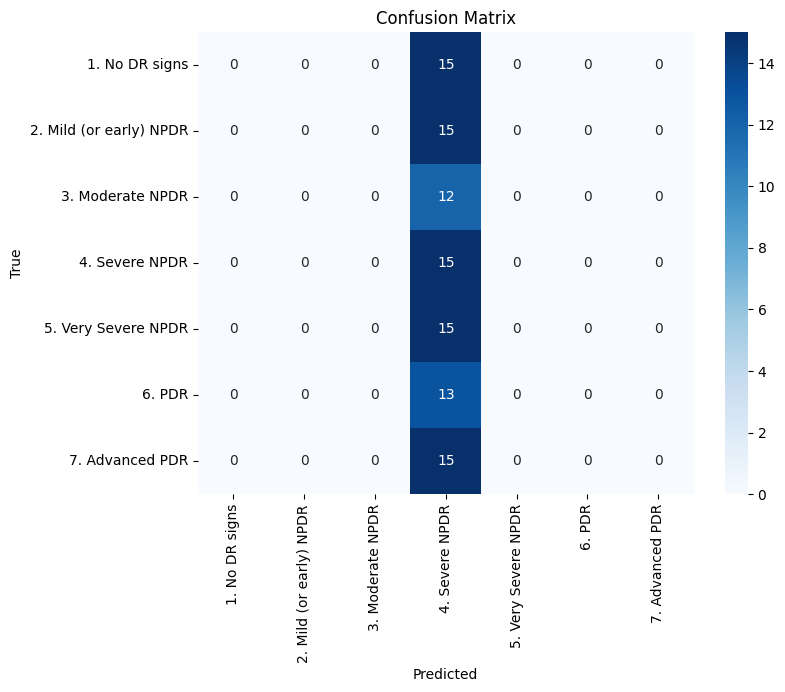

Training Time: 302.67 seconds
Accuracy: 0.1500
Precision: nan
Recall (Sensitivity): 0.1429
F1-Score: nan
Specificity: -inf


<ipython-input-3-756f702e1344>:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
<ipython-input-3-756f702e1344>:19: RuntimeWarning: divide by zero encountered in divide
  specificity = TN / (TN + FP)


In [3]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")